# Natural Language Processing- Word Embeddings

The objective of the notebook was to get experience in natural language processing using Word2Vec, PCA, LLE and t-SNE; and analyze the embeddings to observe similarities between words in the given corpus, as well as to compare the different embeddings to the original (Word2Vec) embedding.

The 'claim' feature of the Climate-Fever dataset taken from the Huggingface database was taken as the corpus for this notebook. The dataset has 1535 sentences. The claim_labels which classify the sentences into those that support a claim (0), reject a claim (1), and those that do not have enough evidence (2), were kept for the purpose of embedding analysis. The similarity analysis was done between neighboring vectors in the embeddings which were listed using k-Neighbor graphing. 

The libraries used are the Datasets library from Huggingface; the nltk library for text preprocessing; Gensim.models for Word2Vec and gensim.utils for some utility functions; and sklearn for PCA, LLE and t-SNE, besides pandas, numpy, seaborn and matplotlib for general operations and plotting. Some modules had to be downloaded such as 'wordnet', 'punkt' etc. from nltk. Such modules were downloaded after the compiler threw an error.

### The notebook was split into the following sections: 

CM1-> Obtaining the corpus, text preprocessing, exploratory data analysis (some visualization), Word2Vec embedding and similarity analysis, arithmetic computations on the embedding, Comparison of arithmetic computation using pre-trained models

CM2-> PCA embedding and similarity analysis; comparison between Wor2Vec and PCA embeddings

CM3-> LLE embedding and similarity analysis; comparison between Wor2Vec and LLE embeddings

CM4-> t-SNE embedding and similarity analysis; comparison between Wor2Vec and t-SNE embeddings

## Question 1: Representation Learning for Text Embedding (CM1)
### Obtaining the Corpus:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Load Climate-Fever dataset:
import datasets
dataset = datasets.load_dataset('climate_fever', split = 'test');

Using custom data configuration default
Reusing dataset climate_fever (C:\Users\rahul\AppData\Roaming\SPB_Data\.cache\huggingface\datasets\climate_fever\default\1.0.1\3b846b20d7a37bc0019b0f0dcbde5bf2d0f94f6874f7e4c398c579f332c4262c)


In [3]:
#Convert dataset to pandas DataFrame:
dataset = dataset.to_pandas()
#Display sample of dataset:
dataset.head()

,claim,claim_id,claim_label,evidences
0,Global warming is driving polar bears toward e...,0,0,[{'article': 'Extinction risk from global warm...
1,The sun has gone into ‘lockdown’ which could c...,5,0,"[{'article': 'Famine', 'entropy': 0.0, 'eviden..."
2,The polar bear population has been growing.,6,1,"[{'article': 'Polar bear', 'entropy': 0.693147..."
3,Ironic' study finds more CO2 has slightly cool...,9,1,"[{'article': 'Atmosphere of Mars', 'entropy': ..."
4,Human additions of CO2 are in the margin of er...,10,1,[{'article': 'Carbon dioxide in Earth's atmosp...


In [4]:
#Get the list of all sentences from the 'claim' feature as the text body:
text = dataset.claim.to_list()

In [5]:
dataset.claim_label.value_counts()

0    654
2    474
1    253
3    154
Name: claim_label, dtype: int64

### Text Preprocessing:
Before the text was embedded using Word2Vec, some cleaning and preprocessing was done. First, all the text was set to lowercase to avoid distinction between the same words with different capitalizations as the embedding functions are case-sensitive. Second, the contractions such as don't, can't etc. were fixed using the contractions library (contractions.fix). The punctuations and numbers were removed using the regular expressions library. Then, the words in each sentence were tokenized using nltk function word_tokenize, after which the stop words (the, all, in etc.) were removed from the tokenized corpus. The process of Stemming and Lemmatization was considered for the corpus. From the experiments, stemming using the PorterStemmer and SnowballStemmer from nltk did not result in good root words. On the other hand, lemmatization using the WordNetLemmatizer did not work well for the corpus without POS tokens as the default considers all words nouns, but worked well with POS tokens (better than stemming). Hence the corpus was lemmatized which resulted in the final preprocessed corpus.

The preprocessing flow was referenced from the articles 'Text Preprocessing with NLTK' (https://towardsdatascience.com/text-preprocessing-with-nltk-9de5de891658) and 'Text Preprocessing in Python: Steps, Tools, and Examples' (https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908). 

In [7]:
#Text Preprocessing:
import string
import re
import nltk
import contractions

stop_words = nltk.corpus.stopwords.words('english')+[" "]+[""]

for i in range(len(text)-1):
    #Change all uppercase letters to lowercase:
    text[i] = text[i].lower()
    #Expand contractions:
    text[i] = contractions.fix(text[i])
    #Remove all punctuation marks:
    text[i] = re.sub(r'[^\w\s]',' ',text[i])
    #Remove all numbers: 
    text[i] = re.sub(r'\d+','',text[i])
    #Tokenize the sentences:
    text[i] = nltk.word_tokenize(text[i])
    #Remove stopwords, empty spaces, simgle character words:
    text[i] = [x for x in text[i] if x not in stop_words and len(x)>1]

In [8]:
#Stemming test:
p_stemmer = nltk.stem.PorterStemmer()
s_stemmer = nltk.SnowballStemmer("english")

temp = ["hardly","warming","better","slightly","tried","cause","studies"]
print([p_stemmer.stem(x) for x in temp],"\n")
print([s_stemmer.stem(x) for x in temp])

['hardli', 'warm', 'better', 'slightli', 'tri', 'caus', 'studi'] 

['hard', 'warm', 'better', 'slight', 'tri', 'caus', 'studi']


From the above test, it can be seen that stemming does not take into account the lemma or actual root word as it happens in lemmatizing (below). It is also evident that the snowball stemmer is objectively better than the porter stemmer.

In [9]:
#Lemmatization without POS:
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()
print([lemmatizer.lemmatize(x) for x in temp],"\n")

['hardly', 'warming', 'better', 'slightly', 'tried', 'cause', 'study'] 



Lemmatizing without POS tagging leads to the lemmatizer treating all tokens as nouns, which results in the above situation. To rectify and get proper lemmas, part of speech tagging is required. The below code snippet does the POS tagging, converts it to the wordnet form, and lemmatizes each word based on the tag. 

The code was referenced from the article 'Lemmatization Approaches with Examples in Python' by Selva Prabhakaran (https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#wordnetlemmatizerwithappropriatepostag)

In [10]:
#Lemmatization with POS:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    #Map POS tag to first character lemmatize() accepts(wordnet format):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN) #Default is noun

#Lemmatize every word in list of list:
for i in range(len(text)-1):
    for j in range(len(text[i])-1):
        text[i][j] = lemmatizer.lemmatize(text[i][j], get_wordnet_pos(text[i][j]))
    #Make sure the lemmatized words do not fall under stop words/single characters:
    text[i] = [x for x in text[i] if x not in stop_words and len(x)>1]

Getting the full list of unique words, i.e., tokens in the corpus, the effectiveness of the NLTK lemmatizer with POS tagging can be observed-

In [11]:
#Get all unique words:
full_list=[]
for i in range(len(text)-1):
    for j in range(len(text[i])-1):
        full_list.append(text[i][j])
all_tokens = list(set(full_list)) #(To get only the unique strings)
print("Number of unique tokens: ",len(all_tokens),"\n")
print("Sample of unique tokens->",all_tokens[0:20],"\n")

Number of unique tokens:  3135 

Sample of unique tokens-> ['spot', 'maintain', 'reveals', 'generous', 'swift', 'discovery', 'penalize', 'giant', 'manifest', 'statewide', 'ambitious', 'barrier', 'write', 'bergen', 'renewable', 'easily', 'force', 'due', 'lake', 'notion'] 



### Exploratory Data Analysis:
Some analysis was done on the data to identify words that occur frequently (which may thus have richer meanings). The most frequently occuring words were displayed in a Word Cloud. Also, all the words which occured less than 10 times in the corpus were discarded. Some adjustments to the text body were also made in light of the data analysis.

The methods were referenced from the blog post 'Exploratory Data Analysis for Natural Language Processing: A Complete Guide to Python Tools' by Shahul ES (https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools)

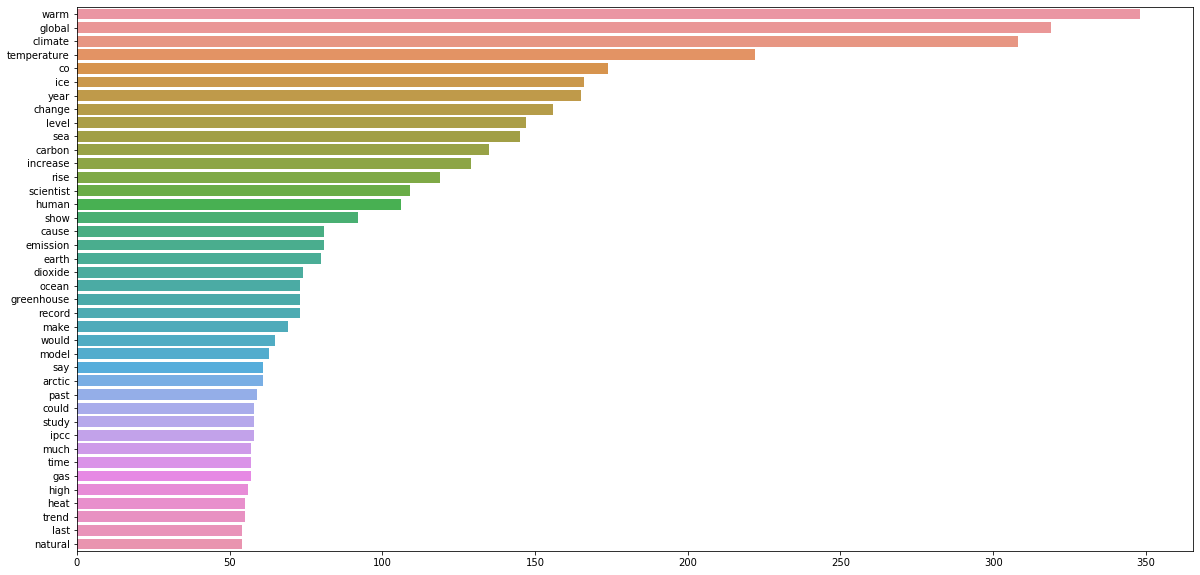

In [12]:
#Word frequency- most frequently occuring words
import collections
import seaborn as sns
counter=collections.Counter(full_list)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop_words):
        x.append(word)
        y.append(count)
fig = plt.figure(figsize=(20,10))
sns.barplot(x=y,y=x);

From the above plot, it can be observed that 'warm' is the most frequently occuring term (~350), while 'global' and 'climate' come close, having frequency greater than 300. Also from the plot, some combinations of words such as 'sea' and 'level' which have same counts are obviously meant to go together. For simplicity, such words were left uncombined. On the other hand, 'increase' and 'rise' are very close in frequency and share the same meaning and context. Intuitively, the words should be similar. 

'co', 'carbon' and 'dioxide' share a different kind of relation here. Some of the 'carbon' terms belong alongside 'dioxide' while the rest should be standalone. While there is definitely a relation between carbon and carbon dioxide (carbon + oxygen = carbon dioxide), it is doubtful if such a relation can be captured from this text body. Sentences containg the link between oxygen and carbon would be required for that connection.

In addition to understanding the data better, taking advantage of the estabilished Counter, all the tokens having frequency  lower than 20 were removed from the corpus in this step (code below). The number of tokens in the corpus then is 146.

In [13]:
#Discarding words occuring less than 20 times in corpus:
for i in range(len(text)-1):
    text[i] = [word for word in text[i] if int(counter[word])>19]

full_list=[]
for i in range(len(text)-1):
    for j in range(len(text[i])-1):
        full_list.append(text[i][j])
all_tokens = list(set(full_list)) #(To get only the unique strings)
print("Number of unique tokens: ",len(all_tokens),"\n")

Number of unique tokens:  146 



From the above calculation, it can be seen that there are only 146 tokens in the corpus after preprocessing and elimination of infrequent (frequency<20) tokens. This agrees well with the list of unique tokens generated from the claims in the paper describing the Climate-Fever dataset- 'CLIMATE-FEVER: A Dataset for Verification of Real-World Climate Claims' by T. Diggelmann, J. Boyd-Graber, J. Bulian, M. Ciaramita, and M. Leipold (https://www.researchgate.net/publication/346555104), where the authors state there are 150 most important tokens (including a few bigrams).    

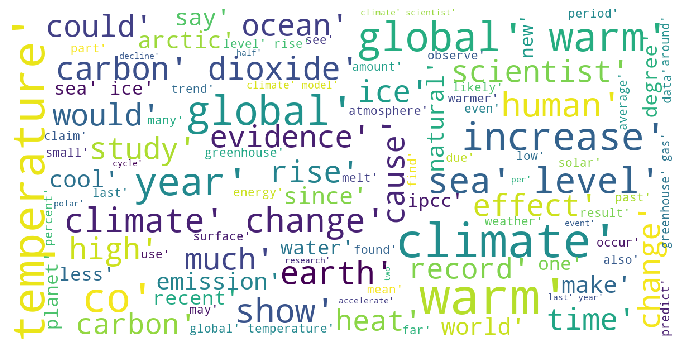

In [14]:
#Wordcloud:
from wordcloud import WordCloud, STOPWORDS
stops = set(STOPWORDS)

wordcloud = WordCloud(background_color='white',stopwords=stops,max_words=100,max_font_size=30,scale=3,random_state=0)
wordcloud=wordcloud.generate(str(full_list))

fig = plt.figure(1,figsize=(12, 12))
plt.axis('off')

plt.imshow(wordcloud)
plt.show()

In the wordcloud, some obvious bigrams can be observed- climate change, carbon dioxide, and global warm(ing). While these phrases were not added to the corpus, it is good to know their presence. 

In [15]:
#Train-test split:(1228,307)
train_set = text[0:1227]
test_set = text[1228:1534]

## CM1 Part 1: 
### Word2Vec Embedding over the entire corpus (train and test set)
The original word2vec embedding model was created for the corpus using the Gensim Word2Vec function. As suggested in the clarifications on Piazza, the word2vec model was built using the entire corpus(training + testing). In the process of training the model, first the model was initialized with the parameters in the below code snippet. As the algorithm uses the continuous bag of words method as default, it is expected that the implicit relationships between the words are somewhat represented in the embedding. 

The vector size was set to 50, for which the similarity results were satisfactory. Further testing was done for size = 100, the average similarity between neighbors for the embedding space increased, and by all accounts higher dimensionality should ensure more hidden relationships are found. However, it may mean that the associations between the words (similarity) becomes exaggerated, hence size = 50 was retained. A negative sampling of 10 was set to ensure the model does not draw false relationships between words. From experiments done (results not shown here), a negative sampling of 0 drastically decreased the similarity between words, making the model near useless for learning. Negative sampling of 5 and 10 worked well. The window size was set to 2.

The building of the vocabulary and training of the model on the dataset are split into two steps for clarity. Another argument of note is the number of training epochs the dataset is subjected to. Increasing this parameter allowed the model to discriminate between the words better, however, it also led to highly similar words being farther apart in similarity than they should be. Hence, due to the small dataset, the number of epochs was set to 30, which was enough to not bunch all the words together, but also not so high that the meaningful connections are broken up. 

The bags of words for the training and testing split sets were then taken and vectors for each bag were found from the trained model.

The reference for this part was from the Gensim API reference for Word2Vec (https://radimrehurek.com/gensim/models/word2vec.html).

In [16]:
#Word2Vec Embedding:
from gensim.models import Word2Vec
model = Word2Vec(min_count=20,window=2,size=50,negative=10,seed=0)

In [17]:
model.build_vocab(text)

In [18]:
model.train(text,total_examples=model.corpus_count,epochs=30)
model.save("word2vec.model");

In [19]:
word_vectors = model.wv #Dictionary of vectors for each token.

With the token-vector dictionary at hand, the test and training set vector were found:

In [20]:
#Unique items in test set (bag of words):
testlist=[]
for i in range(len(test_set)-1):
    for j in range(len(test_set[i])-1):
        testlist.append(test_set[i][j])
test_tokens = set(testlist)

In [289]:
test_vectors = word_vectors[test_tokens]

In [22]:
#Unique items in train set (bag of words):
trainlist=[]
for i in range(len(train_set)-1):
    for j in range(len(train_set[i])-1):
        trainlist.append(train_set[i][j])
train_tokens = set(trainlist)

In [23]:
train_vectors = word_vectors[train_tokens]

In [24]:
len(test_vectors)

141

In [25]:
len(train_vectors)

146

In [26]:
all_tokens = test_tokens.union(train_tokens)
len(word_vectors[all_tokens])

146

## CM1 Part 2:
### Analysis of Word2Vec embedding space (test set vectors)
To analyze the embedding space, first the top similarities of important words (from the visualizations in the previous section) were observed. After getting an idea of the space, the neighbors of each vector were found in the embedding space using the sklearn kneighbors graph function. From the matrix returned by the function, the cosine simmilarities between each pair of neighbors were found and the similarity values were averaged over the entire set. Further evaluation of the embedding was done using knn (discussed more later).

In [27]:
#Checking if words with similar context are similar (Preliminary evaluation):

similarity = word_vectors.similarity('cloud', 'atmosphere')
print(f"'cloud', 'sun': {similarity:.4f}\n")
similarity = word_vectors.similarity('temperature', 'warm')
print(f"'temperature', 'warm': {similarity:.4f}\n")
similarity = word_vectors.similarity('cool', 'warm')
print(f"'cool', 'warm': {similarity:.4f}\n")
similarity = word_vectors.similarity('temperature', 'degree')
print(f"'temperature', 'degree': {similarity:.4f}\n")
similarity = word_vectors.similarity('review', 'paper')
print(f"'review', 'paper': {similarity:.4f}\n")
similarity = word_vectors.similarity('ocean','long')
print(f"'scientist', 'gas': {similarity:.4f}\n")
similarity = word_vectors.similarity('extreme', 'ice')
print(f"'extreme', 'ice': {similarity:.4f}\n")
similarity = word_vectors.similarity('carbon', 'accord')
print(f"'carbon', 'accord': {similarity:.4f}\n")

'cloud', 'sun': 0.9620

'temperature', 'warm': 0.9805

'cool', 'warm': 0.9950

'temperature', 'degree': 0.9903

'review', 'paper': 0.8252

'scientist', 'gas': 0.8770

'extreme', 'ice': 0.6671

'carbon', 'accord': 0.7395



Just from a preliminary look using the above relations, it can be observed that shallow relationships have been formed by the model. 'cloud' and 'sun', 'temperature' and 'degree', 'review' and 'paper' all have relatively high similarity compare to the pairs of 'extreme' and 'ice' or 'carbon' and 'accord'. While this is not sufficient to evaluate the embedding, it can be said that it somewhat works. Further looking at list of similar words for some tokens (nearest neighbors)->

In [28]:
result = word_vectors.most_similar('temperature')
print("Words most similar to 'temperature' with similarity scores:\n\n",result)
result = word_vectors.most_similar('warm')
print("\nWords most similar to 'warm' with similarity scores:\n\n",result)
result = word_vectors.most_similar('arctic')
print("\nWords most similar to 'arctic' with similarity scores:\n\n",result)
result = word_vectors.most_similar('dioxide')
print("\nWords most similar to 'dioxide' with similarity scores:\n\n",result)
result = word_vectors.most_similar('sea')
print("\nWords most similar to 'sea' with similarity scores:\n\n",result)
result = word_vectors.most_similar('ocean')
print("\nWords most similar to 'ocean' with similarity scores:\n\n",result)

Words most similar to 'temperature' with similarity scores:

 [('warmer', 0.9911268949508667), ('show', 0.9910339117050171), ('period', 0.9909160733222961), ('degree', 0.9902938604354858), ('planet', 0.9900715947151184), ('surface', 0.9884389638900757), ('half', 0.988142728805542), ('even', 0.9870049953460693), ('observe', 0.9853751063346863), ('past', 0.984803318977356)]

Words most similar to 'warm' with similarity scores:

 [('cool', 0.9950402975082397), ('natural', 0.9905056357383728), ('sun', 0.9886387586593628), ('period', 0.9881769418716431), ('cycle', 0.9871165752410889), ('global', 0.9856026768684387), ('planet', 0.9836512804031372), ('show', 0.9834149479866028), ('half', 0.9831357598304749), ('evidence', 0.9831090569496155)]

Words most similar to 'arctic' with similarity scores:

 [('melt', 0.9963986873626709), ('antarctica', 0.9886726140975952), ('accelerate', 0.9866421222686768), ('greenland', 0.9742289185523987), ('rate', 0.9680543541908264), ('polar', 0.9641940593719482)

From the above calculations, the relationships between the embedded vectors can be observed. While for quite a few words, the model has identified other words close in meaning as similar, it fails to do so for some others. A notable failure is for the word 'ocean' which has clearly been placed in the wrong neighborhood. On the other hand, 'arctic' is well connected to words close in context and meaning to it, such as 'melt', 'antarctica', 'ice' and 'greenland'. This exposes the need for a larger dataset so that the correct connections between the words are maintained and the mistakes rectified. 

Another point to note is that many of the words considered similar by the model are those that appear alongside the word in consideration, i.e, are n-grams, and do not have much in common from a lexical perspective. 

Below, the embedding space is analyzed using the kneighbors graph, which allows us to see the average similarity scores for the embedding, get the recall@k value for the embedding as well as the knn accuracy, which can be used to evaluate the embedding. 

In [232]:
#Analyzing the word2vec embedding of the test set:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csr_matrix

N = [1,2,4,8,16,32]
avg_cossim_w2v = [0,0,0,0,0,0]
for n in [0,1,2,3,4,5]:
    #Get neighbors and similarities for all test_vectors using kneighbors graph:
    mat = kneighbors_graph(test_vectors, N[n], metric='cosine', mode='distance', include_self=False)
    mat.data = 1 - mat.data  # to similarity
    #Getting average cosine similarity between each test_vector and its neighbors:
    avg_cossim_w2v[n] = mat.sum()/mat.count_nonzero()

print("Average cosine similarity for Word2Vec embedding:\n")
print("k = 1: ",avg_cossim_w2v[0])
print("k = 2: ",avg_cossim_w2v[1])
print("k = 4: ",avg_cossim_w2v[2])
print("k = 8: ",avg_cossim_w2v[3])
print("k = 16: ",avg_cossim_w2v[4])
print("k = 32: ",avg_cossim_w2v[5])

Average cosine similarity for Word2Vec embedding:

k = 1:  0.9893233928274601
k = 2:  0.9875319460605053
k = 4:  0.9848724798107824
k = 8:  0.9806166845010528
k = 16:  0.9739706702266179
k = 32:  0.9658328658300088


In the above code snippet, the number of neighbors is arbitrarily taken as 8, for which the average cosine similarity from the kneighbors graph was found to be 0.98. By increasing the number of neighbors(second argument in nkneighbors_graph()), it was possible to observe that the average similarity value dropped, which was as expected from the embedding space. The high cosine similarity values can be attributed to the fact that the dataset is too small to generate more meaningful relationships between the words. 

To get the recall@k and accuracy values, it is neccessary to label the vectors so that the retrieved queries can be evaluated as relevant or not. Since the Climate-Fever dataset came with claim_labels, they were used to determine the labels for the vector samples. Most tokens in the corpus belong to multiple sentences, some having different claim_labels. This led to each vector having multiple counts of one or more labels. The label under which each vector occured most frequently was assigned to that vector.

In [275]:
#Getting labels for the words:

#Write the list of tokens into a dataframe->
df = pd.DataFrame(np.column_stack([list(all_tokens)]),columns=['tokens'])
header_list = ['tokens','count0','count1','count2','count3']
df = df.reindex(columns = header_list)
df = df.fillna(0)

#Then for each token, search for instances in claims. If present in claim, update count of labels associated with the token->
temp_count = 0

for i in range(len(df)-1):
    df.loc[i,'count0']=0
    df.loc[i,'count1']=0
    df.loc[i,'count2']=0
    df.loc[i,'count3']=0
    for j in range(len(text)-1):
        if df.tokens[i] in text[j]:
            temp_count = text[j].count(df.tokens[i])
            if dataset.claim_label[j] == 0:
                df.loc[i,'count0']=df.count0[i]+temp_count
            elif dataset.claim_label[j] == 1:
                df.loc[i,'count1']=df.count1[i]+temp_count
            elif dataset.claim_label[j] == 2:
                df.loc[i,'count2']=df.count2[i]+temp_count
            else:
                df.loc[i,'count3']=df.count3[i]+temp_count

#Got a table of tokens and labels associated with them. Now, for each token assign the label with highest count->

conditions = [
    (df['count0']>df['count1'])&(df['count0']>df['count2'])&(df['count0']>df['count3']),
    (df['count1']>df['count0'])&(df['count1']>df['count2'])&(df['count1']>df['count3']),
    (df['count2']>df['count0'])&(df['count2']>df['count1'])&(df['count2']>df['count3']),
    (df['count3']>df['count0'])&(df['count3']>df['count1'])&(df['count3']>df['count2'])
     ]
values = [0,1,2,3]
df['label'] = np.select(conditions,values)

In [315]:
#To get test set vectors labels: 
df_2 = pd.DataFrame(np.column_stack([df['tokens'].tolist(),df['label'].tolist()]))
test_label_dict = dict(df_2.values)
test_labels = list(map(test_label_dict.get,test_tokens))
test_labels = [int(i) for i in test_labels]

In [277]:
df.label.value_counts()

0    119
2     26
1      1
Name: label, dtype: int64

From the label values above, it can be observed that most tokens belong to label = 0, with a smaller fraction belonging to label = 2. Label = 1 on the other hand has only one vector. This is the classification breakdown of the testing set embedding. 

To further evaluate the embedding, recall@k values are found for a few values of k. The code for recall@k is taken from https://github.com/chaoyuaw/incubator-mxnet/blob/master/example/gluon/embedding_learning/train.py.

In [320]:
#To get recall@k, first find distance matrix using kneighbors graph:
mat = kneighbors_graph(test_vectors, len(test_vectors), metric='cosine', mode='distance', include_self=True)
mat = mat.toarray()
labels = test_labels

accs = []
for k in [1,2,4,8,16,32]:
    correct,count = 0,0
    for i in range(test_vectors.shape[0]-1):
        mat[i,i]=1e10
        nns = np.argpartition(mat[i],k)[:k]
        if any(labels[i]==labels[nn] for nn in nns):
            correct += 1
        count += 1
    accs.append(correct/count)
print("Recall@1 = ", accs[0],"\n")
print("Recall@2 = ", accs[1],"\n")
print("Recall@4 = ", accs[2],"\n")
print("Recall@8 = ", accs[3],"\n")
print("Recall@16 = ", accs[4],"\n")
print("Recall@32 = ", accs[5],"\n")

Recall@1 =  0.6857142857142857 

Recall@2 =  0.8285714285714286 

Recall@4 =  0.9142857142857143 

Recall@8 =  0.9642857142857143 

Recall@16 =  0.9928571428571429 

Recall@32 =  0.9928571428571429 



In the above code, the numpy argpartition function separates out the first k indices of the distance values for the ith vector, i.e., allows the next line of code to query the k nearest neighbors of the ith vector. The calculated recall@ values are displayed above. 

As expected from the embedding, the recall@ value increases sharply with increase in k. This is because most vectors belong to label = 0, and the more the neighbors considered, the higher the proportion of "correctly" labeled vectors. On the other hand, the low recall@1 value suggests a significant portion of the nearest neighbors do not belong to the same labels.

## CM1 Part 3:
### Compute 5 arithmetic relationships
To further evaluate the quality of the embedding, some arithmetic computations were tried using the word vectors from the whole embedding space. The simple computations were chosen intuitively from the list of high frequency words and the wordcloud in the visualization section. 

The computations:

1) temperature+change-increase=?(expected: cool/cold)

2) heat+sea+level=?(rise)

3) climate+study=ipcc (since that is the predominant organization in the corpus)

4) greenhouse+gas=emission (worked)

5) research+study=scientific (worked)

In [208]:
#Arithmetic computations:
result = word_vectors.most_similar(positive=['temperature','change'],negative=['increase'])
most_similar_key, similarity = result[0]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

scientist: 0.9579


The algorithm did not catch the relationships between heat and cold as temperature changes. This may need a larger dataset.

In [348]:
result = word_vectors.most_similar(positive=['heat','sea','level'])
most_similar_key, similarity = result[0]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

rise: 0.9904


The combination of the words sea level and heat resulted in 'rise' which is expected from the claims made in the dataset. 

In [349]:
result = word_vectors.most_similar(positive=['ice','temperature'],negative=['cool'])
most_similar_key, similarity = result[0] # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")
#expected: melting/melt/water

sheet: 0.9719


It is expected that if you remove cool from the temperature of ice, the result should be melting, melt, or water etc. This relationship does not seem to have registered with the model. On the other hand, the word resulted in is 'sheet' which should occur in text as ice sheets in the arctic or polar region, which in claims have been mentioned to be melting. That is probably the cause of this result.

In [350]:
result = word_vectors.most_similar(positive=['gas','greenhouse'])
most_similar_key, similarity = result[0]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

emission: 0.9822


In [351]:
result = word_vectors.most_similar(positive=['effect','global'])
most_similar_key, similarity = result[0]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

heat: 0.9946


From the trials made to arrive at acceptable intuitive word arithmetic relations, it can be said that there is a lot of room for improvement in the model. The dataset is too small for a deep and meaningful network of words to be formed, which is required to get certain computation results from the model. 

## CM1 Part 4:
### Load pre-trained model, get arithmetic relations scores
To compare the effectiveness of pre-trained models in identifying arithmetic relationships between words, the corpus was fed through, i.e., trained using pre-trained models imported from the gensim library (using gensim.downloader()). The 'glove-wiki-gigaword-50' and the 'word2vec-google-news-300' datasets selected from gensim database were used as no Glove and Word2Vec models exist which were trained on the same dataset. The same arithmetic relationships as tried out in the previous part (3) were done using the vectors trained using the pre-trained models, and the results were compared.

In [72]:
import gensim.downloader as api
import json
from gensim.test.utils import datapath

glove_vectors = api.load('glove-wiki-gigaword-50')
wv_vectors = api.load('word2vec-google-news-300')

In [87]:
glove_words = list(glove_vectors.vocab.keys())

In [88]:
wv_words = list(wv_vectors.vocab.keys())

In [90]:
model_1 = Word2Vec(size=50,min_count=1)
model_2 = Word2Vec(size=300,min_count=1)

model_1.build_vocab(text)
model_2.build_vocab(text)

total_examples = model_1.corpus_count

To save on memory and keep track of each process, the following steps are divided one to each cell. The steps include adding the vocabulary of the pre-trained models with associated weights to the word2vec models instanced above. model_1 corresponds to the pre-trained Glove model and model_2 corresponds to the pre-trained word2vec model.

In [ ]:
model_1.build_vocab([glove_words],update=True)

In [93]:
model_2.build_vocab([wv_words],update=True)

In [96]:
glove_vectors.save_word2vec_format('glove.bin',binary=True)

In [98]:
wv_vectors.save_word2vec_format('wvecs.bin',binary=True)

In [97]:
model_1.intersect_word2vec_format('glove.bin',binary=True,lockf=1.0)

In [100]:
model_2.intersect_word2vec_format('wvecs.bin',binary=True,lockf=1.0)

In [101]:
model_1.train(text, total_examples=total_examples,epochs=1)

(8243, 8243)

In [102]:
model_2.train(text, total_examples=total_examples,epochs=1)

(8220, 8243)

In [103]:
glovept_vectors = model_1.wv
wvpt_vectors = model_2.wv

### Performing the same arithmetic computations using the Glove pre-trained model as on the original trained model,

In [112]:
#Arithmetic Computations using pre-trained Glove model:
result = glovept_vectors.most_similar(positive=['temperature','change'],negative=['increase'])
most_similar_key, similarity = result[0]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

cool: 0.7268


In [227]:
result = glovept_vectors.most_similar(positive=['heat','sea','level'])
most_similar_key, similarity = result[0]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

water: 0.8375


In [127]:
result = glovept_vectors.most_similar(positive=['effect','global'])
most_similar_key, similarity = result[0]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

impact: 0.9176


In [217]:
result = glovept_vectors.most_similar(positive=['gas','greenhouse'])
most_similar_key, similarity = result[0]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

carbon: 0.9011


In [224]:
result = glovept_vectors.most_similar(positive=['ice','temperature'],negative=['cool'])
most_similar_key, similarity = result[0] # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

melting: 0.6845


### Performing the same computations on the Word2Vec pretrained model,

In [212]:
result = wv_vectors.most_similar(positive=['temperature','change'],negative=['increase'])
most_similar_key, similarity = result[0]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

temperatures: 0.5452


In [213]:
result = wv_vectors.most_similar(positive=['global','warming','sea','level'])
most_similar_key, similarity = result[0]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

GHG_concentrations: 0.5915


In [214]:
result = wv_vectors.most_similar(positive=['effect','global'])
most_similar_key, similarity = result[0]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

impact: 0.5576


In [215]:
result = wv_vectors.most_similar(positive=['gas','greenhouse'])
most_similar_key, similarity = result[0]  # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

natural_gas: 0.6428


In [223]:
result = wv_vectors.most_similar(positive=['ice','temperature'],negative=['cool'])
most_similar_key, similarity = result[0] # look at the first match
print(f"{most_similar_key}: {similarity:.4f}")

temperatures: 0.5141


From the above results (both from glove and word2vec models), the pretraining allowed the arithmetic computations to become more and more relevant, even if the results were not as expected. Notably, the pretraining with the glove model had the best results for the arithmetic computations, which is somewhat expected as the claims in ClimateFever were modeled off of Wikipedia which is what the glove model was trained on. On the other hand, the word2vec pre-trained model is a much larger model trained on a massive number of news articles, which would require quite a few epochs for training. Due to time constraints, only one epoch of training was done and so the effects of using pre-trained models for transfer-learning are not obvious.

## Question 2:Representation Learning and dimensionality Reduction, Part 1: PCA
Principal Component Analysis was performed on the Word2Vec embeddings of the training set split obtained from the previous section. The number of dimensions was tuned using an obtained scree plot from the PCA embedding of train set. The obtained best number of dimensions was used to train the PCA encoder which was applied to the test set to get embeddings for evaluation and comparison with the Word2Vec embeddings. 
## CM2 Part 1:
### Applying PCA on train set W2V embeddings->

To do PCA, get the embeddings of train set: train_vectors.

Train PCA with different number of components and get scree plot

Test PCA on the test set embeddings: test_vectors

Get pairplots between first four PCA dimensions (1-2,1-3,1-4,2-3,2-4,3-4)

Evaluate PCA embedding using the exact same methods as for w2v embedding:

    First check cosine similarity between 3 word pairs out of those already used for w2v
    
    Second, get knn graph and average cosine similarity for k = 10,50,100
    
    Third, get knn graph and recall@k
    
    Fourth, get knn graph and compute knn accuracy

In [134]:
from sklearn.decomposition import PCA
pca = PCA()
train_PCA = pca.fit(train_vectors)
eigenvalues = pca.explained_variance_
n_components = [i+1 for i in range(len(eigenvalues))]

## CM2 Part 2:
### Scree plot and identifying best number of components to retain

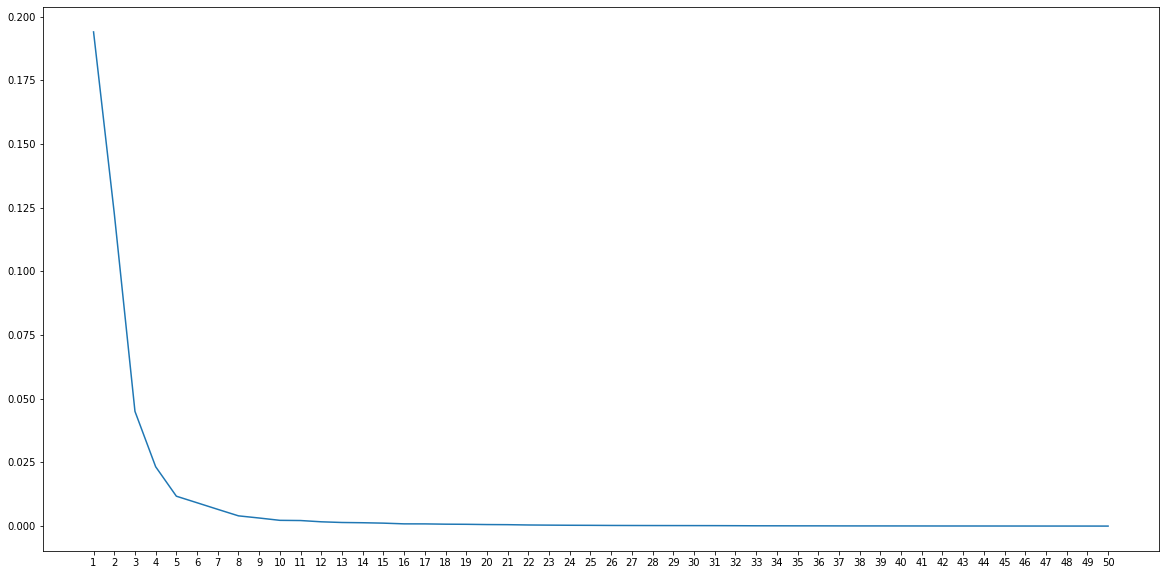

In [143]:
#Scree Plot:
fig = plt.figure(figsize=(20,10))
plt.plot(n_components,eigenvalues)
plt.xticks(n_components);

From the Scree plot above, the knee and thus a good number of components to keep is 5. The PCA embedder is trained using the number of components on the training set embeddings:

In [144]:
pca2 = PCA(n_components = 5)
train_PCA2 = pca2.fit(train_vectors)
test_PCA2 = pca2.transform(test_vectors)

## CM2 Part 3:
### Plotting the first four dimensions against each other (pairplots), 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


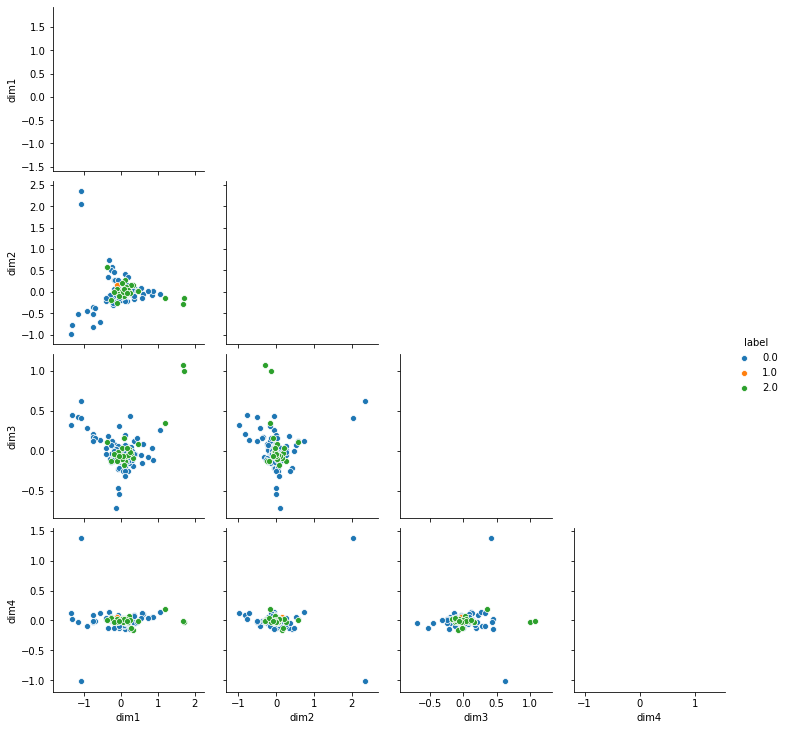

In [322]:
dim1 = test_PCA2[:,0]
dim2 = test_PCA2[:,1]
dim3 = test_PCA2[:,2]
dim4 = test_PCA2[:,3]

dim_df = pd.DataFrame(np.column_stack([dim1,dim2,dim3,dim4,test_labels]),columns=['dim1','dim2','dim3','dim4','label'])

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

g = sns.pairplot(dim_df,hue='label');
g.map_upper(hide_current_axis);
g.map_diag(hide_current_axis);

From the pairplots, it can be seen that most of the data is tightly clustered around (0,0). There appear to be some outliers at the edges of the plots in all 6 different plots. These four dimensions carry most of the information in the word2vec embeddings as observed from the scree plot where over 75% of the variance is due to the first 4 components. 

From the plot between the first and second dimensions, it is possible to observe some clusters which tell us that those words are close in meaning and can be distinguished from the others by distance. However the majority of points are uniformly and densely distributed around the center, which shows the need for more training data in the wor2vec model, since the words are not easily distinguishable by distance measures. Similarly, this pattern is somewhat repeated between dimensions one and three, as well as between two and three. This indicates the possibility of local neighborhood associations in the data across dimensions, which will be explored using LLE in the next sections. From the looks of it, there are four distinguishable word clusters.

## CM2 Part 4:
### Evaluating PCA embeddings and comparing to Word2Vec embeddings
Using the same measures as on the test set word2vec embeddings, average cosine similarity and recall@k for a range of k values were calculated for the PCA embeddings of the test set. Some conclusions could be made based on the comparison between the two embeddings.

Before the kneighbor graph based analysis, a few of the word pairs used as examples of similarity and dissimilarity in CM1 were taken and the cosine similarities between their respective PCA embeddings were found to get a feeling for the differences between the embeddings.

In [343]:
from scipy.spatial.distance import cosine

wordsonlist = ['cool','warm','temperature','degree','review','paper','ocean','long','extreme', 'ice']
word_list = pca2.transform(word_vectors[wordsonlist])

similarity = 1-cosine(word_list[0],word_list[1])
print(f"'cool', 'warm': {similarity:.4f}\n")
similarity = 1-cosine(word_list[2],word_list[3])
print(f"'temperature', 'degree': {similarity:.4f}\n")
similarity = 1-cosine(word_list[4],word_list[5])
print(f"'review', 'paper': {similarity:.4f}\n")
similarity = 1-cosine(word_list[6],word_list[7])
print(f"'ocean', 'long': {similarity:.4f}\n")
similarity = 1-cosine(word_list[8],word_list[9])
print(f"'extreme', 'ice': {similarity:.4f}\n")

'cool', 'warm': 0.9636

'temperature', 'degree': 0.8565

'review', 'paper': 0.8429

'ocean', 'long': -0.0268

'extreme', 'ice': -0.8458



From the above examples, it can be seen that the false similarity between 'ocean' and 'long' in the word2vec embeddings has been rectified in the PCA embeddings, while all remaining values are somewhat consistent with their word2vec counterparts.

In [323]:
N = [1,2,4,8,16,32]
avg_cossim_pca = [0,0,0,0,0,0]
for n in [0,1,2,3,4,5]:
    #Get neighbors and similarities for all test_vectors using kneighbors graph:
    mat = kneighbors_graph(test_PCA2, N[n], metric='cosine', mode='distance', include_self=False)
    mat.data = 1 - mat.data  # to similarity
    #Getting average cosine similarity between each test_vector and its neighbors:
    avg_cossim_pca[n] = mat.sum()/mat.count_nonzero()

print("Average cosine similarity for Word2Vec embedding:\n")
print("k = 1: ",avg_cossim_pca[0])
print("k = 2: ",avg_cossim_pca[1])
print("k = 4: ",avg_cossim_pca[2])
print("k = 8: ",avg_cossim_pca[3])
print("k = 16: ",avg_cossim_pca[4])
print("k = 32: ",avg_cossim_pca[5])

Average cosine similarity for Word2Vec embedding:

k = 1:  0.9646123791417331
k = 2:  0.954840693913453
k = 4:  0.9389488274324025
k = 8:  0.9106956103169326
k = 16:  0.8590124684868129
k = 32:  0.7561522138879654


In [324]:
#To get recall@k, first find distance matrix using kneighbors graph:
mat = kneighbors_graph(test_PCA2, len(test_PCA2), metric='cosine', mode='distance', include_self=True)
mat = mat.toarray()
labels = test_labels

accs = []
for k in [1,2,4,8,16,32]:
    correct,count = 0,0
    for i in range(test_PCA2.shape[0]-1):
        mat[i,i]=1e10
        nns = np.argpartition(mat[i],k)[:k]
        if any(labels[i]==labels[nn] for nn in nns):
            correct += 1
        count += 1
    accs.append(correct/count)
print("Recall@1 = ", accs[0],"\n")
print("Recall@2 = ", accs[1],"\n")
print("Recall@4 = ", accs[2],"\n")
print("Recall@8 = ", accs[3],"\n")
print("Recall@16 = ", accs[4],"\n")
print("Recall@32 = ", accs[5],"\n")

Recall@1 =  0.7214285714285714 

Recall@2 =  0.8571428571428571 

Recall@4 =  0.8928571428571429 

Recall@8 =  0.95 

Recall@16 =  0.9928571428571429 

Recall@32 =  0.9928571428571429 



As compared to the word2vec embedding, the recall@k performance is better for the pca embedding. While it is not that significant, when taken together with the fact that cosine similarity drop off rate with increase in k is higher, it can be concluded that the words with same label as assigned by us are closer together than in the word2vec embeddings and the words are in general more clustered and not spread out through the embedding space. 

## Question 2:Representation Learning and dimensionality Reduction, Part 2: LLE
Locally Linear Embedding implementation from sklearn was used to complete this task with the number of components set to 4 as per the requirements. The other parameters were left as is. It was suggested that the LLE embedding be done on the test set, but as out of sample embedding is possible with the newer versions of the sklearn implementation, the embedding was learnt on the train set and tested on the test set vectors. The four dimensionalities were plotted against each other similar to PCA embedding using sns.pairplot() from seaborn. The embeddings were then compared to the word2vec embeddings based on average cosine similarity for k neighbors and recall@k values.
## CM3 Part 1:
### Applying LLE embedding (train using train set and apply on test set)

In [325]:
from sklearn.manifold import LocallyLinearEmbedding

embedding = LocallyLinearEmbedding(n_neighbors=8, n_components=4)
embedding.fit(train_vectors)
test_LLE = embedding.transform(test_vectors)

## CM3 Part 2:
### Plotting the four dimensions against each other (pairsplot)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


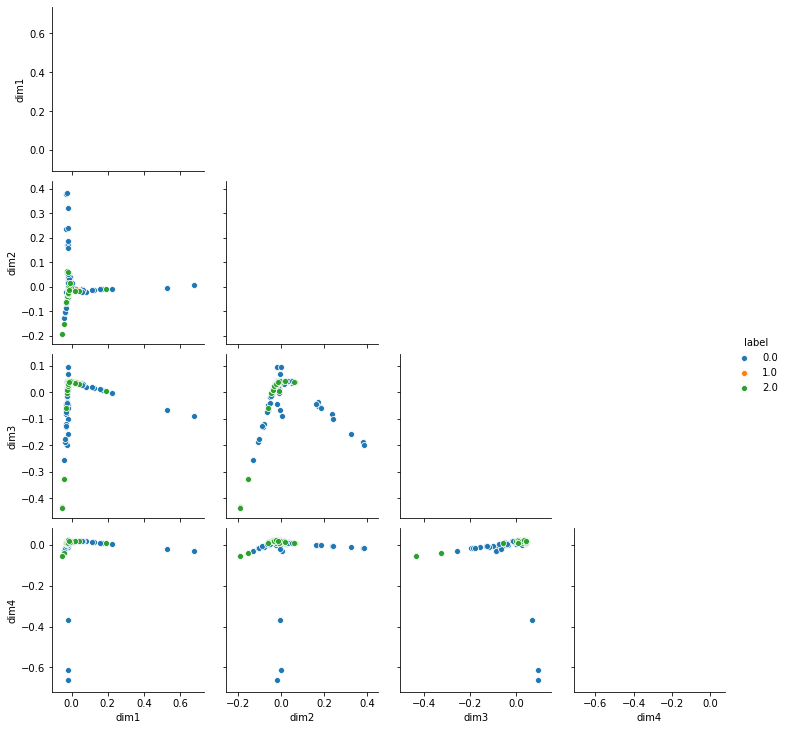

In [326]:
dim1 = test_LLE[:,0]
dim2 = test_LLE[:,1]
dim3 = test_LLE[:,2]
dim4 = test_LLE[:,3]

dim_df = pd.DataFrame(np.column_stack([dim1,dim2,dim3,dim4,test_labels]),columns=['dim1','dim2','dim3','dim4','label'])

g = sns.pairplot(dim_df,hue='label');
g.map_upper(hide_current_axis);
g.map_diag(hide_current_axis);

The expectations from the PCA dimensionality pairsplot were validated here. It is clear from the LLE embedding that the Word2Vec embedding space is a manifold along some dimensions. The LLE embedding preserved the neighborhood grouping of the test vectors while extracting the nonlinear features from the word2vec embedding. 

## CM3 Part 3:
### Evaluating LLE embeddings and comparing to Word2Vec embeddings
Similar to the PCA and Word2Vec embeddings, the LLE embedding was first analyzed by checking similarity between preciously used word pairs. The kneighbors graph of the embedding was used to get average cosine similarity and recall@ for a range of k values such that the embedding can be evaluated. 

In [353]:
wordsonlist = ['cool','warm','temperature','degree','review','paper','ocean','long','extreme', 'ice']
word_list2 = embedding.transform(word_vectors[wordsonlist])

similarity = 1-cosine(word_list2[0],word_list2[1])
print(f"'cool', 'warm': {similarity:.4f}\n")
similarity = 1-cosine(word_list2[2],word_list2[3])
print(f"'temperature', 'degree': {similarity:.4f}\n")
similarity = 1-cosine(word_list2[4],word_list2[5])
print(f"'review', 'paper': {similarity:.4f}\n")
similarity = 1-cosine(word_list2[6],word_list2[7])
print(f"'ocean', 'long': {similarity:.4f}\n")
similarity = 1-cosine(word_list2[8],word_list2[9])
print(f"'extreme', 'ice': {similarity:.4f}\n")

'cool', 'warm': 0.9852

'temperature', 'degree': 0.9719

'review', 'paper': 0.9915

'ocean', 'long': -0.1466

'extreme', 'ice': -0.7541



From the comparison between the similarity values from PCA and Word2Vec, the values above seem much better- as obvious connections between 'review' and 'paper', 'cool' and 'warm' seem to have become much closer, while words like 'ocean' and 'long' are still apart, much farther away compared to the word2vec trained model. Continuing to find the kneighbors graph and find average similarity and recall@k,

In [354]:
N = [1,2,4,8,16,32]
avg_cossim_LLE = [0,0,0,0,0,0]
for n in [0,1,2,3,4,5]:
    #Get neighbors and similarities for all test_vectors using kneighbors graph:
    mat = kneighbors_graph(test_LLE, N[n], metric='cosine', mode='distance', include_self=False)
    mat.data = 1 - mat.data  # to similarity
    #Getting average cosine similarity between each test_vector and its neighbors:
    avg_cossim_LLE[n] = mat.sum()/mat.count_nonzero()

print("Average cosine similarity for LLE embedding:\n")
print("k = 1: ",avg_cossim_LLE[0])
print("k = 2: ",avg_cossim_LLE[1])
print("k = 4: ",avg_cossim_LLE[2])
print("k = 8: ",avg_cossim_LLE[3])
print("k = 16: ",avg_cossim_LLE[4])
print("k = 32: ",avg_cossim_LLE[5])

Average cosine similarity for LLE embedding:

k = 1:  0.9958865274328151
k = 2:  0.994644284229007
k = 4:  0.982189873705279
k = 8:  0.9689975560864362
k = 16:  0.9254033708997275
k = 32:  0.8081003041264355


In [355]:
#To get recall@k, first find distance matrix using kneighbors graph:
mat = kneighbors_graph(test_LLE, len(test_LLE), metric='cosine', mode='distance', include_self=True)
mat = mat.toarray()
labels = test_labels

accs = []
for k in [1,2,4,8,16,32]:
    correct,count = 0,0
    for i in range(test_PCA2.shape[0]-1):
        mat[i,i]=1e10
        nns = np.argpartition(mat[i],k)[:k]
        if any(labels[i]==labels[nn] for nn in nns):
            correct += 1
        count += 1
    accs.append(correct/count)
print("Recall@1 = ", accs[0],"\n")
print("Recall@2 = ", accs[1],"\n")
print("Recall@4 = ", accs[2],"\n")
print("Recall@8 = ", accs[3],"\n")
print("Recall@16 = ", accs[4],"\n")
print("Recall@32 = ", accs[5],"\n")

Recall@1 =  0.6714285714285714 

Recall@2 =  0.8428571428571429 

Recall@4 =  0.8785714285714286 

Recall@8 =  0.95 

Recall@16 =  0.9857142857142858 

Recall@32 =  0.9928571428571429 



The jump in recall@ after k=8 is because the number of neighbors for the embedder was set to 8. Since the LLE does local neighborhood grouping, recall@ increases sharply after k=8. The values of average similarity are also greater for LLE embeddings than both either PCA or Word2Vec embeddings. This shows that the LLE embedding preserves the linear distances very well when reducing the dimensionality, thereby bunching similar words closer together providing meaningful context as observed from the examples at the first step of evaluation.

## Question 2:Representation Learning and dimensionality Reduction, Part 3: t-SNE
In contrast to PCA and LLE, t-Distributed Stochastic Neighbor Embedding is mainly used for visualization of high-dimensional data. The Barnes-Hut approximation method used for real world datasets is in fact limited to two or three dimensional embeddings. The t-SNE is a probabilistic method and pays particular attention to maintaining the local data clusters, rather than unfolding any continuous manifolds as observed in LLE embedding. As the method aims to solve the crowding problem and does so convincingly, it would be better to have a two dimensional embedding of the word2vec embeddings. 
## CM4 Part 1:
### Applying t-SNE on word2vec embeddings (n_components = 2)
Since out-of-sample embedding cannot be done using this method, the t-SNE is applied on the test set embeddings. The number of embedding dimensions is two, due to the above discussed reasons. The sklearn implementation of t-SNE was used with the perplexity set to 8, as it is somewhat related to the number of neighbors taken in other methods and provides the (visually) best scatter plot, and random_state=0. 

In [387]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,random_state=0,metric='euclidean',perplexity=8)
test_TSNE = tsne.fit_transform(test_vectors)

## CM4 Part 2:
### Visualize the t-SNE embedding

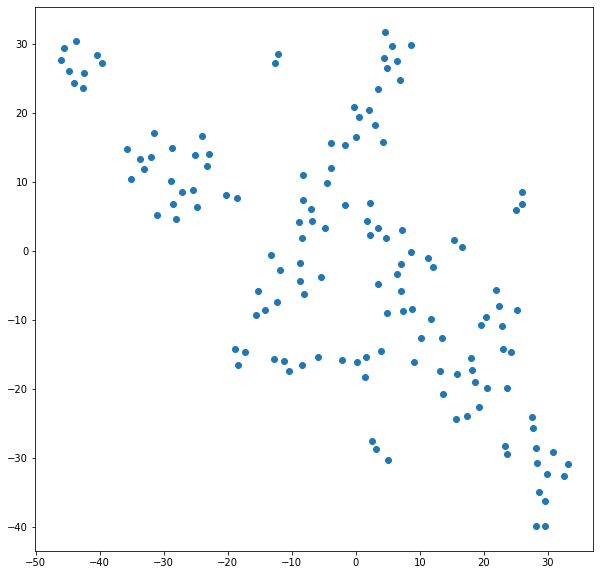

In [388]:
fig = plt.figure(figsize=(10,10))
plt.scatter(test_TSNE[:,0],test_TSNE[:,1]);

Since the algorithm is non-linear and operated differently in regions according to the local patterns, the distances between the observed clusters as well as the relative sizes of the clusters are not accurate representations of actual relationships. We can observe from the plot somewhere near 12 clusters for the 141 token test vectors set, which could be the actual number of overarching topics represented by the dataset. 

## CM4 Part 3:
### Evaluating t-SNE embedding and comparing it to word2vec embedding->
Although the distances are somewhat meaningless when it comes to the t-SNE embeddings, the cosine similarities are still valid in evaluating the embeddings. The kneighbors graph was found for the embedding and the average similarities and recall@k values were found.

In [389]:
N = [1,2,4,8,16,32]
avg_cossim_TSNE = [0,0,0,0,0,0]
for n in [0,1,2,3,4,5]:
    #Get neighbors and similarities for all test_vectors using kneighbors graph:
    mat = kneighbors_graph(test_TSNE, N[n], metric='cosine', mode='distance', include_self=False)
    mat.data = 1 - mat.data  # to similarity
    #Getting average cosine similarity between each test_vector and its neighbors:
    avg_cossim_TSNE[n] = mat.sum()/mat.count_nonzero()

print("Average cosine similarity for TSNE embedding:\n")
print("k = 1: ",avg_cossim_TSNE[0])
print("k = 2: ",avg_cossim_TSNE[1])
print("k = 4: ",avg_cossim_TSNE[2])
print("k = 8: ",avg_cossim_TSNE[3])
print("k = 16: ",avg_cossim_TSNE[4])
print("k = 32: ",avg_cossim_TSNE[5])

Average cosine similarity for TSNE embedding:

k = 1:  0.9992532933011968
k = 2:  0.9982206736896055
k = 4:  0.9965437219498006
k = 8:  0.991042657946864
k = 16:  0.9740849488170434
k = 32:  0.9167746685920878


As expected from the embedding, the average similarities between each vector and its neighbors are extremely high, at least at below and around the perplexity value, as lower perplexity leads to more local focus rather than global. Comparing to all other methods, this has the highest average cosine similarity.

In [390]:
#To get recall@k, first find distance matrix using kneighbors graph:
mat = kneighbors_graph(test_TSNE, len(test_TSNE), metric='cosine', mode='distance', include_self=True)
mat = mat.toarray()
labels = test_labels

accs = []
for k in [1,2,4,8,16,32]:
    correct,count = 0,0
    for i in range(test_TSNE.shape[0]-1):
        mat[i,i]=1e10
        nns = np.argpartition(mat[i],k)[:k]
        if any(labels[i]==labels[nn] for nn in nns):
            correct += 1
        count += 1
    accs.append(correct/count)
print("Recall@1 = ", accs[0],"\n")
print("Recall@2 = ", accs[1],"\n")
print("Recall@4 = ", accs[2],"\n")
print("Recall@8 = ", accs[3],"\n")
print("Recall@16 = ", accs[4],"\n")
print("Recall@32 = ", accs[5],"\n")

Recall@1 =  0.6928571428571428 

Recall@2 =  0.8357142857142857 

Recall@4 =  0.9071428571428571 

Recall@8 =  0.9428571428571428 

Recall@16 =  0.9857142857142858 

Recall@32 =  0.9928571428571429 



The recall@ values are comparable to the other models, but still the recall@8 is less than that of the LLE embedding and word2vec embedding, which is because of the relative inattention of the algorithm to global patterns in the embedding space. However there is not a significant difference due to most labels being 0 and only a few labels being otherwise. 